In [1]:
#this file seeks to evaluate some common tree distances

In [1]:
import stdpopsim
import os
import tskit
import msprime
import numpy as np
import subprocess
import matplotlib.pyplot as plt
from IPython.display import display, SVG
import json
import bisect

In [ ]:
import dendropy
from Espalier import MAF
def spr_dist_tree(tree1:tskit.Tree,tree2:tskit.Tree):
    #only for tree with 1 root
    if (tree1.num_roots>1 or tree2.num_roots>1):
        return None
    tree1_newick = tree1.as_newick()
    tree2_newick = tree2.as_newick()

    # Parse into dendropy trees
    taxon_namespace = dendropy.TaxonNamespace()
    t1 = dendropy.Tree.get(data=tree1_newick, schema="newick", taxon_namespace=taxon_namespace)
    t2 = dendropy.Tree.get(data=tree2_newick, schema="newick", taxon_namespace=taxon_namespace)


    t1.is_rooted = True
    t2.is_rooted = True

    t1.resolve_polytomies()
    t2.resolve_polytomies()

    if set([leaf.taxon.label for leaf in t1.leaf_node_iter()]) != set([leaf.taxon.label for leaf in t2.leaf_node_iter()]):
        print(f"Tree have mismatched taxa")


    # ass dendropy trees to Espalier
    spr_distance = MAF.get_spr_dist(t1, t2)
    return spr_distance
    
def spr_dist_ts(ts1:tskit.TreeSequence,ts2:tskit.TreeSequence,x1,x2):#x1 and x2 are positions
    assert(len(x1)==len(x2))
    all_dist=[]
    tree1=ts1.at(0)
    tree2=ts2.at(0)
    for i in range(len(x1)):
        tree1.seek(x1[i])
        tree2.seek(x2[i])
        all_dist.append(spr_dist_tree(tree1,tree2))
    return np.array(all_dist)

def kc_dist_ts(ts1:tskit.TreeSequence,ts2:tskit.TreeSequence,x1,x2,lam=0):#x1 and x2 are positions
    assert(len(x1)==len(x2))
    all_dist=[]
    tree1=ts1.at(0,sample_lists=True)
    tree2=ts2.at(0,sample_lists=True)
    for i in range(len(x1)):
        tree1.seek(x1[i])
        tree2.seek(x2[i])
        if (tree1.num_roots>1 or tree2.num_roots>1):
            all_dist.append(None)
        else:
            all_dist.append(tree1.kc_distance(tree2,lam))
    return np.array(all_dist)
def rf_dist_ts(ts1:tskit.TreeSequence,ts2:tskit.TreeSequence,x1,x2):#x1 and x2 are positions on the genome
    assert(len(x1)==len(x2))
    all_dist=[]
    tree1=ts1.at(0,sample_lists=True)
    tree2=ts2.at(0,sample_lists=True)
    for i in range(len(x1)):
        tree1.seek(x1[i])
        tree2.seek(x2[i])
        if (tree1.num_roots>1 or tree2.num_roots>1):
            all_dist.append(None)
        else:
            all_dist.append(tree1.rf_distance(tree2))
    return np.array(all_dist)

In [3]:
# high_cov_within_40_49_dis=spr_dist_ts(index40_all_ts[0],index49_all_ts[0],grch_x,grch_x)

# full_high_cov_within_40_49_dis=np.stack((grch_x,grch_x,high_cov_within_40_49_dis))
# np.save("./distance_file/high_cov_within_40e6_42e6_40_49_dis.npy",full_high_cov_within_40_49_dis)

In [6]:
dir="./simulations/"
names=["Ne2e4_100_1e6","Ne2e4_1000_1e6","Ne2e4_3000_1e6","ooa_300_1e6","ooa_3000_1e6"]
name1=names[0]
name2=names[3]

In [8]:
pos=[i for i in range(0,int(1e6),10000)]

In [ ]:
#generate distance for bewteen each true ARG and inferred ARG

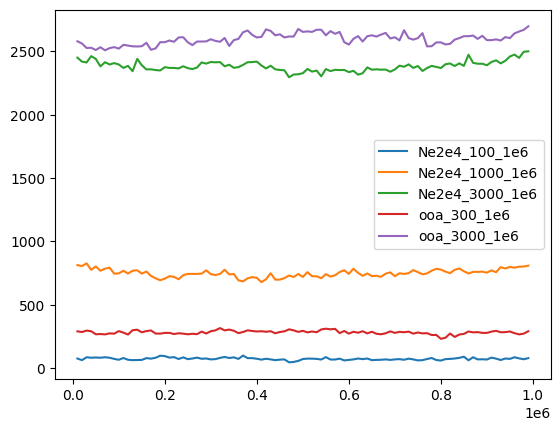

In [16]:
all_rf=[]
for name in names:
    ts=tskit.load(dir+name+"/"+name+".trees")
    inferred_ts=tskit.load(dir+name+"/"+name+"-inferred.trees").simplify()
    test_dis=rf_dist_ts(ts,inferred_ts,pos,pos)
    all_rf.append(test_dis)
i=0
for rf in all_rf:
    plt.plot(pos,rf,label=names[i])
    i+=1
plt.legend()

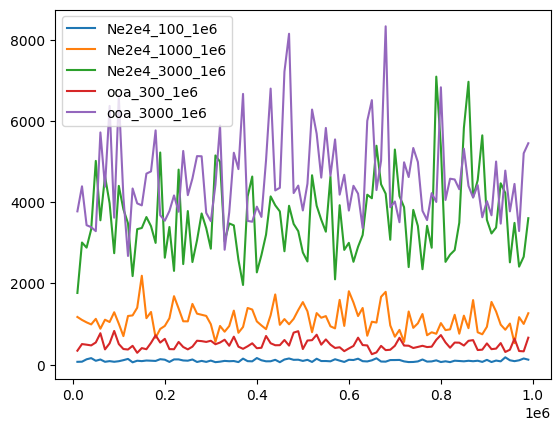

In [18]:
all_kc=[]
for name in names:
    ts=tskit.load(dir+name+"/"+name+".trees")
    inferred_ts=tskit.load(dir+name+"/"+name+"-inferred.trees").simplify()
    test_dis=kc_dist_ts(ts,inferred_ts,pos,pos)
    all_kc.append(test_dis)
i=0
for kc in all_kc:
    plt.plot(pos,kc,label=names[i])
    i+=1
plt.legend()

Text(0.5, 1.0, 'spr')

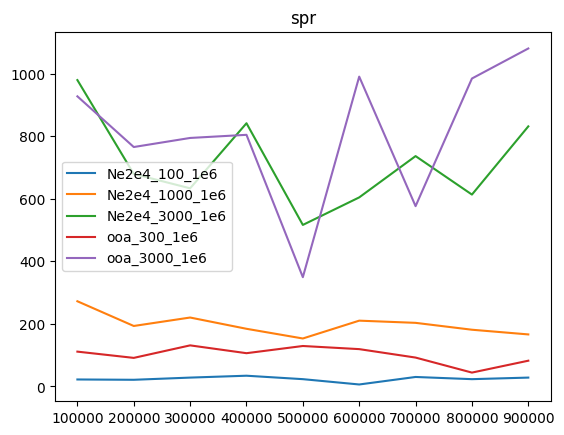

In [20]:
pos=[i for i in range(0,int(1e6),100000)]
all_spr=[]
for name in names:
    ts=tskit.load(dir+name+"/"+name+".trees")
    inferred_ts=tskit.load(dir+name+"/"+name+"-inferred.trees").simplify()
    test_dis=spr_dist_ts(ts,inferred_ts,pos,pos)
    all_spr.append(test_dis)
i=0
for spr in all_spr:
    plt.plot(pos,spr,label=names[i])
    i+=1
plt.legend()
plt.title("spr")

In [13]:
random_2e4_100_ts=msprime.sim_ancestry(samples=50,population_size=2e4,recombination_rate=1e-8,sequence_length=1e6)

INFO: Sampling 50 individuals with ploidy 2 in population 0 (name='pop_0') at time 0
INFO: Starting replicate 0
INFO: model[0] {'name': 'hudson'} started at time=0 nodes=100 edges=0
INFO: Running model {'name': 'hudson'} until max time: inf
INFO: Completed at time=361646 nodes=2594 edges=13274


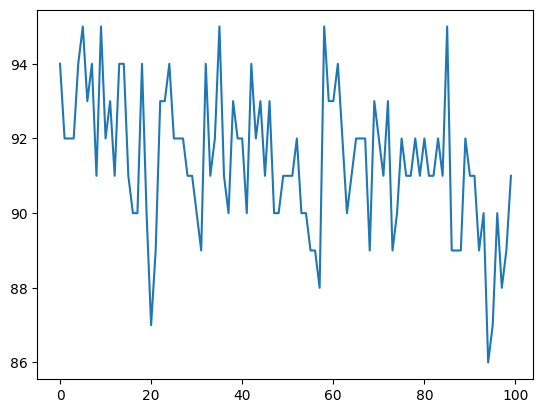

In [15]:
random_spr_dis=spr_dist_ts(Ne2e4_100_ts,random_2e4_100_ts,pos,pos)
plt.plot(random_spr_dis)

In [ ]:
kc_100_dis=kc_dist_ts(Ne2e4_100_ts,Ne2e4_100_inferred_ts,pos,pos)
kc_1000_dis=kc_dist_ts(ooa_300_ts,ooa_300_inferred_ts,pos,pos)

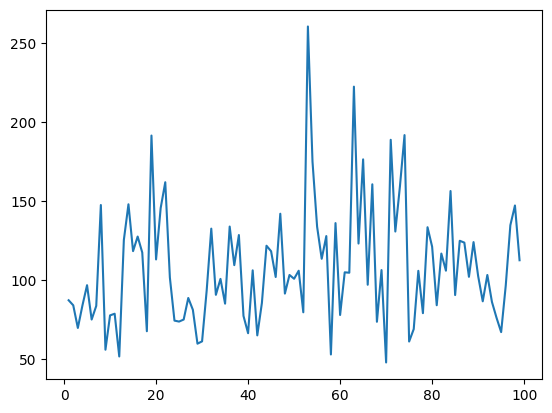

In [37]:
plt.plot(kc_100_dis)

Text(0.5, 1.0, 'kc distance for tree sequence')

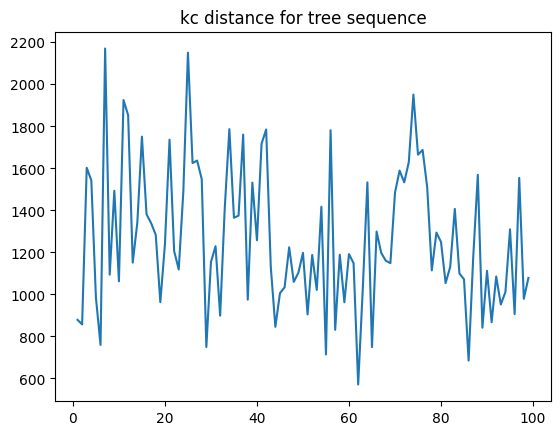

In [40]:
plt.plot(kc_1000_dis)
plt.title("kc distance for tree sequence")

In [46]:
test_1000_ts.sequence_length

1000000.0

In [58]:
next=[]
for i in range(0,int(test_1000_ts.sequence_length)-1000,1000):
    t1=test_1000_ts.at(i,sample_lists=True)
    t2=test_1000_ts.at(i+1000,sample_lists=True)
    next.append(t1.kc_distance(t2))

Text(0.5, 1.0, 'kc distance between trees seperated by 1000 bp')

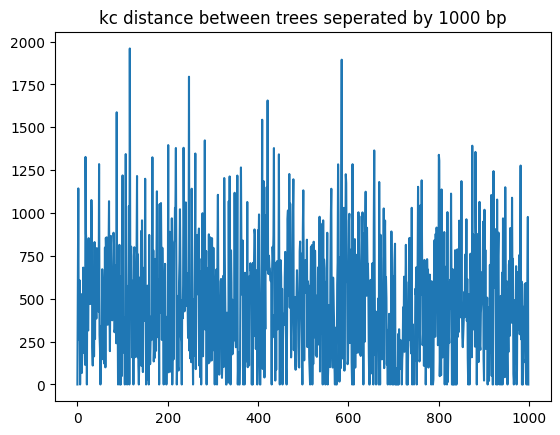

In [60]:
plt.plot(next)
plt.title("kc distance between trees seperated by 1000 bp")

In [52]:
simulated_ts=msprime.sim_ancestry(samples=500,sequence_length=1e6,population_size=1e4,recombination_rate=1e-8)

INFO: Sampling 500 individuals with ploidy 2 in population 0 (name='pop_0') at time 0
INFO: Starting replicate 0
INFO: model[0] {'name': 'hudson'} started at time=0 nodes=1000 edges=0
INFO: Running model {'name': 'hudson'} until max time: inf
INFO: Completed at time=165939 nodes=3945 edges=11974


In [54]:
simulated_ts.at(1,sample_lists=True).kc_distance(test_1000_ts.at(0,sample_lists=True))

2200.8377950226136

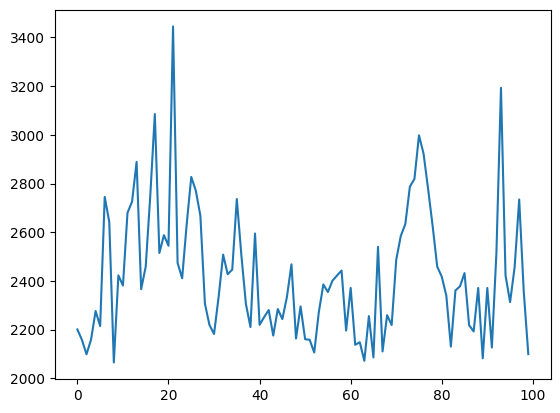

In [57]:
plt.plot(kc_dist_ts(simulated_ts,test_1000_ts,pos,pos))